In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.insert(
    0,
    r"C:\Users\Asus\Desktop\Repo\MasterThesis_RI\Python-Real-World-Machine-Learning\Module 2\Chapter 5",
)

import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
# Classification
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Ranking
import lightgbm as lgb

# Semi-Supervised Learning
from sklearn.semi_supervised import (
    LabelPropagation,
    LabelSpreading,
    SelfTrainingClassifier,
)

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

# Ensembling
from sklearn.ensemble import *

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Binning
import woeBinningPandas

# Create Unique ID
import uuid

<IPython.core.display.Javascript object>

## Data

### Synthetic Data

In [3]:
# Load data
model_ds = pd.read_csv("model_ds.csv")

# Accepted
df3 = model_ds[model_ds["is_accepted"] == 1]
df3 = df3.drop(["is_accepted"], axis=1)
df3 = df3.rename(columns={"y": "target"})
df3["id"] = df3.index.to_series().map(lambda x: uuid.uuid4())
# Rejected
dfr = model_ds[model_ds["is_accepted"] == 0]
dfr = dfr.drop(["is_accepted"], axis=1)

# Create ids for rejects
dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())

# Train/Test Split (without labels)
# Shuffle the dataset
shuffle_df = dfr.sample(frac=1)

# Define a size for your train set
train_size = int(0.7 * len(shuffle_df))

# Split your dataset
dfr_dev3 = shuffle_df[:train_size]
dfr_test3 = shuffle_df[train_size:]

# Drop y
dfr_dev2 = dfr_dev3
dfr_test2 = dfr_test3
dfr_dev3 = dfr_dev3.drop(["y"], axis=1)
dfr_test3 = dfr_test3.drop(["y"], axis=1)

<IPython.core.display.Javascript object>

In [4]:
print(df3.shape)  # accepted
print(dfr.shape)  # rejected
print(dfr_dev3.shape)  # rejected train
print(dfr_test3.shape)  # rejected test

(7000, 11)
(3000, 11)
(2100, 10)
(900, 10)


<IPython.core.display.Javascript object>

In [5]:
dfr_test2 = dfr_test2[
    [
        "id",
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

In [6]:
dfr_dev2 = dfr_dev2[
    [
        "id",
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

In [7]:
dfr_dev3 = dfr_dev3[
    [
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

In [8]:
dfr_test3 = dfr_test3[
    [
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

### FOR SYNTHETIC DATA

In [9]:
# Create X and y
X = df3.loc[:, df3.columns != "target"]
y = df3.loc[:, df3.columns == "target"]

# Train Test Split and Balance data
os = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
columns = X_train.columns

# Train
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=["target"])

# Match names with Lending Club Data
os_data_X_2 = os_data_X
X_test_2 = X_test

<IPython.core.display.Javascript object>

In [10]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(os_data_X_2.shape)
print(X_test_2.shape)

(7000, 10)
(4900, 10)
(2100, 10)
(639, 10)
(2100, 10)


<IPython.core.display.Javascript object>

In [11]:
os_data_X_2 = os_data_X[
    [
        "known_col_0",
        "known_col_1",
        "known_col_3",
        "known_col_4",
    ]
]
X_test_2 = X_test[
    [
        "known_col_0",
        "known_col_1",
        "known_col_3",
        "known_col_4",
    ]
]


<IPython.core.display.Javascript object>

In [12]:
dfr_dev3 = dfr_dev3[
    [
        "known_col_0",
        "known_col_1",
        "known_col_3",
        "known_col_4",
    ]
]
dfr_test3 = dfr_test3[
    [
        "known_col_0",
        "known_col_1",
        "known_col_3",
        "known_col_4",
    ]
]

<IPython.core.display.Javascript object>

In [13]:
# Build Logistic regression
# Statmodels
X_in = sm.add_constant(os_data_X_2.astype(float))
logit_model = sm.Logit(os_data_y, X_in)
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.408557
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.358     
Dependent Variable: target           AIC:              532.1362  
Date:               2021-01-13 18:55 BIC:              554.4357  
No. Observations:   639              Log-Likelihood:   -261.07   
Df Model:           4                LL-Null:          -406.73   
Df Residuals:       634              LLR p-value:      8.0363e-62
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const        -2.0519    0.1867  -10.9880  0.0000  -2.4179  -1.6859
known_col_0  -0.2875    0.1076   -2.6708  0.0076  -0.4985  -0.

<IPython.core.display.Javascript object>

Accuracy score Logistic Regression: 0.8928571428571429


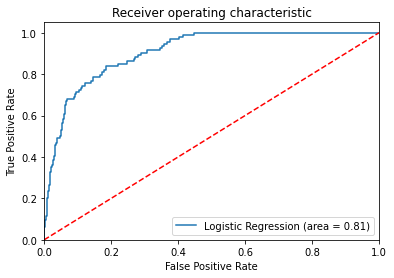

<IPython.core.display.Javascript object>

In [14]:
# Sklearn
logreg = LogisticRegression(fit_intercept=True, penalty="none")
logreg.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = logreg.predict(X_test_2)
print("Accuracy score Logistic Regression:", logreg.score(X_test_2, y_test))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_2)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [15]:
#Test set with labels
test_labels = pd.merge(
    y_test,
    X_test,
    how="inner",
    left_index=True,
    right_index=True,
)


<IPython.core.display.Javascript object>

In [16]:
# Predictions on testset
test_pred = logreg.predict_proba(X_test_2)[:, 1]
test_pred2 = pd.DataFrame(data=test_pred, columns=["prediction"])
test_pred2["count"] = test_pred2.groupby("prediction")["prediction"].transform("count")
test_pred2.groupby(["prediction"]).count()
test_pred2.describe()

,prediction,count
count,2100.000000,2100.0
mean,0.201120,1.0
std,0.229241,0.0
min,0.000032,1.0
25%,0.031407,1.0
50%,0.107643,1.0
75%,0.292498,1.0
max,0.987590,1.0


<IPython.core.display.Javascript object>

In [17]:
# Join predictions with test new
pred_test_kgb = pd.DataFrame(
    data=test_pred, columns=["prediction_beforeRI"], index=y_test.index.copy()
)
pred_test1 = pd.merge(
    test_labels,
    pred_test_kgb[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)

# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
pred_test1

,target,known_col_0,known_col_1,known_col_2,known_col_3,known_col_4,known_col_5,known_col_6,known_col_7,known_col_8,id,prediction_beforeRI
7231,0,0.120288,0.595316,-1.876325,-1.032869,-0.223376,1.164968,0.482257,0.246359,0.860173,4e12d842-1943-4fee-893a-237d2a903c93,0.380206
7880,0,2.069580,0.503860,-0.198736,-0.072057,0.156990,-1.623263,0.474801,-0.026581,0.875270,0b3b1265-5a31-4040-a1a1-05231cd77847,0.161506
3621,0,-0.062990,-0.777283,-0.186030,0.609338,0.202800,0.963561,-0.816584,-0.621179,0.016290,9ac96e63-e2bf-4c51-9227-7a073e3d9f15,0.023516
7836,0,0.448716,0.743112,0.214673,0.814224,-0.386753,1.166083,-0.622785,-0.554206,-1.009237,dca4df9f-07c0-48b2-bcf8-5aaddf192a70,0.195453
7816,0,0.188821,0.944693,-1.229423,0.483918,-1.064125,2.208808,0.786099,-0.210297,0.294476,8f16c496-a5cb-4c21-a70c-612cf86045e4,0.270819
...,...,...,...,...,...,...,...,...,...,...,...,...
5796,0,0.137725,-0.655189,0.259445,0.826849,0.663798,0.222962,0.091939,0.113713,0.880674,bac88347-ede9-4925-8acc-9bca4cb21dba,0.027959
1128,0,-0.020695,-1.029771,-1.882774,-0.890091,0.517958,0.861856,-1.054173,-1.904468,-0.201315,9e2f55a2-1eb8-403a-93a4-6664adc98930,0.037388
3617,0,-0.308260,1.000664,0.484986,1.590688,-0.059050,0.992015,-0.816889,-1.768316,0.026157,293907c1-e6af-4ff4-987c-9c29a1b5444a,0.254521
8491,0,-1.158329,-1.836229,2.523833,-0.061446,-0.130475,0.781090,0.590055,-0.343272,0.356698,0fe8cfe0-d777-4d43-8504-21973acece76,0.006393


<IPython.core.display.Javascript object>

In [18]:
# pred_test1.shape  # Expected nr. of observations

<IPython.core.display.Javascript object>

### Random Forest

In [19]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = rf.predict(X_test_2)
print("Accuracy score Random Forest:", rf.score(X_test_2, y_test))
print("F1 score Random Forest:", f1_score(y_pred, y_test, average="weighted"))

Accuracy score Random Forest: 0.8942857142857142
F1 score Random Forest: 0.87245402599909


<IPython.core.display.Javascript object>

### Decision Tree

In [20]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = dt.predict(X_test_2)
print("Accuracy score Decision Tree:", dt.score(X_test_2, y_test))
print("F1 score Decision Tree", f1_score(y_pred, y_test, average="weighted"))

Accuracy score Decision Tree: 0.7904761904761904
F1 score Decision Tree 0.7323352784536569


<IPython.core.display.Javascript object>

In [21]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1656, 1: 444}

<IPython.core.display.Javascript object>

### SVM

In [22]:
svm = svm.SVC()
svm.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = svm.predict(X_test_2)
print("Accuracy score SVM:", svm.score(X_test_2, y_test))
print("F1 score SVM:", f1_score(y_pred, y_test, average="weighted"))

Accuracy score SVM: 0.87
F1 score SVM: 0.8384502736838335


<IPython.core.display.Javascript object>

### K-Means

In [23]:
km = KMeans(n_clusters=2)
km.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = km.predict(X_test_2)

<IPython.core.display.Javascript object>

### Hierarchical clustering

In [24]:
hc = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hc.fit_predict(os_data_X_2, os_data_y.values.ravel())
y_pred = km.predict(X_test_2)

<IPython.core.display.Javascript object>

### Light GBM Ranker

In [25]:
X_train_GBM, X_val, y_train_GBM, y_val = train_test_split(
    os_data_X_2, os_data_y, test_size=0.2, random_state=1
)

<IPython.core.display.Javascript object>

In [26]:
gbm = lgb.LGBMRanker()

query_train = [X_train_GBM.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test_2.shape[0]]

gbm.fit(
    X_train_GBM,
    y_train_GBM,
    group=query_train,
    eval_set=[(X_val, y_val)],
    eval_group=[query_val],
    eval_at=[5, 10, 20],
    early_stopping_rounds=50,
)

y_pred = gbm.predict(X_test_2)

[1]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.933746	valid_0's ndcg@20: 0.885185
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.838957	valid_0's ndcg@20: 0.896068
[3]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.904077
[4]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.869033
[5]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.870978
[6]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.868407
[7]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.870452
[8]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.905389
[9]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.90247
[10]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.905389
[11]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@2

<IPython.core.display.Javascript object>

In [27]:
X_test_2["prediction_beforeRI"] = test_pred
X_test_2.sort_values("prediction_beforeRI", ascending=False)

,known_col_0,known_col_1,known_col_3,known_col_4,prediction_beforeRI
9648,-1.376924,2.638756,-2.550811,-0.645050,0.987590
1595,-1.923012,2.688573,-0.950701,0.332375,0.982132
8192,-0.573999,3.189136,-0.923375,-1.638883,0.980523
3874,-1.501789,3.138081,0.523119,-1.181993,0.967936
7028,-0.683603,2.430056,-1.087961,0.631205,0.966109
...,...,...,...,...,...
7773,0.289924,-3.031079,0.382012,-0.497031,0.000340
9431,1.650316,-2.459913,1.090615,-1.389713,0.000330
8295,-1.582314,-3.711331,0.076296,0.311418,0.000258
4980,-0.596218,-3.539279,1.554941,-0.030173,0.000103


<IPython.core.display.Javascript object>

(array([1011.,  371.,  200.,  138.,  110.,   79.,   66.,   53.,   38.,
          34.]),
 array([3.15243185e-05, 9.87874011e-02, 1.97543278e-01, 2.96299155e-01,
        3.95055031e-01, 4.93810908e-01, 5.92566785e-01, 6.91322662e-01,
        7.90078539e-01, 8.88834415e-01, 9.87590292e-01]),
 <a list of 10 Patch objects>)

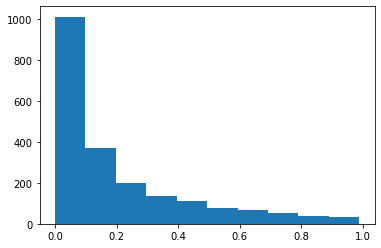

<IPython.core.display.Javascript object>

In [28]:
plt.hist(X_test_2["prediction_beforeRI"], bins=10)

### Function for predictions

Predictions1 uses predict_proba; predictions 2 uses predict

In [29]:
def predictions1(model, treshold):
    # Join predictions with train new
    pred = model.predict_proba(dfr_dev3)[:, 1]
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

In [30]:
def predictions2(model, treshold):
    # Join predictions with train new
    pred = model.predict(dfr_dev3)
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

In [31]:
def predictions1(model, treshold):
    # Join predictions with train new
    pred = model.predict_proba(dfr_dev3)[:, 1]
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

### Predictions

In [32]:
ri1_train = predictions1(logreg, 0.1)  # Logistic Regression
ri2_train = predictions1(dt, 0.1)  # Decision Tree
ri3_train = predictions1(rf, 0.1)  # Random Forest
ri4_train = predictions2(svm, 0.1)  # SVM
ri5_train = predictions2(km, 0.1)  # K-means on Accepts
ri8_train = predictions2(gbm, 0.1)  # Light GBM ranking 0.2
ri9_train = predictions2(gbm, 0.1)  # Light GBM ranking 0.1

<IPython.core.display.Javascript object>

### K-Means

to-do:
- grid search/hypterparameter optimization
- visualization

In [33]:
kmeans = KMeans(
    init="random", n_clusters=2, n_init=10, max_iter=300, random_state=7
).fit(dfr_dev3)

<IPython.core.display.Javascript object>

In [34]:
print("Inertia: ", kmeans.inertia_)
print("Cluster centers: ", kmeans.cluster_centers_)
print("N iter: ", kmeans.n_iter_)
print("Labels: ", kmeans.labels_)

Inertia:  5482.266692389834
Cluster centers:  [[ 0.04736156  0.85490107  0.1662508   1.0491767 ]
 [-0.05036393 -0.75345219  0.25304772  1.08480687]]
N iter:  28
Labels:  [0 1 0 ... 1 1 1]


<IPython.core.display.Javascript object>

### Reject Inference K-means

### Train set

In [35]:
# Predictions
rej_test_predictions_kmeans = kmeans.labels_
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()

,Rejects
prediction,
0,992
1,1108


<IPython.core.display.Javascript object>

In [36]:
# Join predictions with train new
pred_ri = kmeans.labels_
pred_ri2 = pd.DataFrame(
    data=pred_ri, columns=["prediction_beforeRI"], index=dfr_dev2.index.copy()
)
ri6 = pd.merge(
    dfr_dev2,
    pred_ri2[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri6_train = ri6[["id", "prediction_beforeRI"]]
ri6_train

,id,prediction_beforeRI
50,8e61baf3-163f-473a-9e2f-2514ed922a65,0
4045,66d51e2a-7b82-4e3e-ae3c-2b50bdc9cc1e,1
1399,43c0cd8b-4b11-4e53-be17-13c3443abd4f,0
6738,66c5c6e2-4b6e-40de-83b1-9ebf839088bf,1
9886,4ea16ab8-ea25-494f-bfbe-5172fc4dba15,1
...,...,...
9733,b6aed10a-4e4e-4f5d-85d8-cd881228cd57,0
2811,8eb086bc-b99a-4bbe-a6f4-556253fe095c,1
9522,ac3204fb-9b3f-430a-a39b-ca2ed712acd9,1
7219,c75f85db-47b7-4b73-926c-2a3e025b3115,1


<IPython.core.display.Javascript object>

In [37]:
dfr_test3.shape

(900, 4)

<IPython.core.display.Javascript object>

### Test Set

In [38]:
# Predictions
rej_test_predictions_kmeans2 = kmeans.predict(dfr_test3)
df_pred_rej_kmeans2 = pd.DataFrame(
    data=rej_test_predictions_kmeans2,
    columns=["prediction"],
    index=dfr_test3.index.copy(),
)
df_pred_rej_kmeans2["Rejects"] = df_pred_rej_kmeans2.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans2.groupby(["prediction"]).count()

,Rejects
prediction,
0,443
1,457


<IPython.core.display.Javascript object>

In [39]:
# Join predictions with test new
pred_test_ri = kmeans.predict(dfr_test3)
pred_test_ri6 = pd.DataFrame(
    data=pred_test_ri, columns=["prediction_beforeRI"], index=dfr_test2.index.copy()
)
ri6_testing = pd.merge(
    dfr_test2,
    pred_test_ri6[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri6_test = ri6_testing[["id", "prediction_beforeRI"]]
ri6_test

,id,prediction_beforeRI
7870,aadf4eed-686c-4da8-a38a-67195908f32f,0
3305,e944fb81-69b0-4d5b-bb01-2151c0dca919,1
9408,36c90934-5b0a-4a9b-9c7b-517f24bed24c,1
2883,6d015135-b8fa-4be3-9b41-485af161059c,1
2082,50fefde7-6e28-43d8-a5dd-9d1326c18695,1
...,...,...
4682,4cb31357-ffaf-4031-a7eb-d33fd1f695b8,0
2857,3be709b5-8ff2-4c66-87b1-737fd6c40f36,0
6204,e85f3178-51e9-4581-a66e-5bf5f1f8a373,1
2452,ba3319a7-dad5-40fd-8924-c6b92766f57d,1


<IPython.core.display.Javascript object>

In [40]:
# Check correlations
ri6_testing[ri6_testing.columns[1:]].corr()["prediction_beforeRI"][:]

known_col_0           -0.091319
known_col_1           -0.804326
known_col_2           -0.028767
known_col_3            0.017642
known_col_4           -0.023664
known_col_5            0.044695
known_col_6            0.017868
known_col_7            0.023858
known_col_8            0.013452
prediction_beforeRI    1.000000
Name: prediction_beforeRI, dtype: float64

<IPython.core.display.Javascript object>

### Hierarchical Clustering

In [41]:
cluster = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
cluster.fit_predict(dfr_dev3)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<IPython.core.display.Javascript object>

In [42]:
# Predictions
rej_test_predictions_aggl = cluster.labels_
df_pred_rej_aggl = pd.DataFrame(data=rej_test_predictions_aggl, columns=["prediction"])
df_pred_rej_aggl["Rejects"] = df_pred_rej_aggl.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_aggl.groupby(["prediction"]).count()

,Rejects
prediction,
0,1105
1,995


<IPython.core.display.Javascript object>

In [43]:
# Join predictions with train new
pred_ri_aggl = cluster.labels_
pred_ri_aggl2 = pd.DataFrame(
    data=pred_ri_aggl,
    columns=["prediction_beforeRI"],
    index=dfr_dev2.index.copy(),
)
ri7 = pd.merge(
    dfr_dev2,
    pred_ri_aggl2[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri7_train = ri7[["id", "prediction_beforeRI"]]
ri7_train

,id,prediction_beforeRI
50,8e61baf3-163f-473a-9e2f-2514ed922a65,0
4045,66d51e2a-7b82-4e3e-ae3c-2b50bdc9cc1e,0
1399,43c0cd8b-4b11-4e53-be17-13c3443abd4f,0
6738,66c5c6e2-4b6e-40de-83b1-9ebf839088bf,1
9886,4ea16ab8-ea25-494f-bfbe-5172fc4dba15,0
...,...,...
9733,b6aed10a-4e4e-4f5d-85d8-cd881228cd57,1
2811,8eb086bc-b99a-4bbe-a6f4-556253fe095c,0
9522,ac3204fb-9b3f-430a-a39b-ca2ed712acd9,0
7219,c75f85db-47b7-4b73-926c-2a3e025b3115,0


<IPython.core.display.Javascript object>

In [44]:
# Check correlations
ri7[ri7.columns[1:]].corr()["prediction_beforeRI"][:]

known_col_0           -0.102015
known_col_1            0.698889
known_col_2           -0.007352
known_col_3           -0.160536
known_col_4            0.017272
known_col_5            0.004758
known_col_6            0.033745
known_col_7            0.019076
known_col_8            0.001049
prediction_beforeRI    1.000000
Name: prediction_beforeRI, dtype: float64

<IPython.core.display.Javascript object>

### Evaluation Measures

In [45]:
def print_results(data, state, prediction):
    print(
        "The number of accurately classified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 1)
            | (data.target == 0) & (data[prediction] == 0)
        ].shape[0],
    )
    print(
        "The number of misclassified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 0)
            | (data.target == 0) & (data[prediction] == 1)
        ].shape[0],
    )

<IPython.core.display.Javascript object>

In [46]:
def evaluation(ri_data):  # ri1_train, ri2_train, etc..

    # TRAIN NEW
    # Join labels to train set
    # Accepts
    train_accepts = pd.merge(
        os_data_X, os_data_y[["target"]], how="left", left_index=True, right_index=True
    )

    train_accepts["Flag1"] = "Accept"

    # Rejects
    train_rejects = pd.merge(
        dfr_dev2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    train_accepts.dropna(subset=["target"], inplace=True)
    train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

    # Concatenate Train Accepts and Train Rejects
    train_new = pd.concat([train_accepts, train_rejects])

    # Flag
    train_new["Flag"] = train_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )
    train_new = train_new.drop(columns=["Flag1"])

    # Retrain KGB Model

    # Split
    X_new = train_new.loc[:, train_new.columns != "target"]
    X_new = X_new.loc[:, X_new.columns != "Flag"]
    y_new = train_new.loc[:, train_new.columns == "target"]
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.3, random_state=7
    )

    # Keep only columns for modelling
    os_data_X_2_new = X_train_new[
        [
            "known_col_0",
            "known_col_1",
            "known_col_3",
            "known_col_4",
        ]
    ]
    X_test_2_new = X_test_new[
        [
            "known_col_0",
            "known_col_1",
            "known_col_3",
            "known_col_4",
        ]
    ]

    # Build Logistic regression
    logreg = LogisticRegression(fit_intercept=False, penalty="none")
    logreg.fit(os_data_X_2_new, y_train_new.values.ravel())

    # TEST NEW
    # Join labels to test set
    # Accepts
    test_accepts = pd.merge(
        X_test, y_test[["target"]], how="left", left_index=True, right_index=True
    )

    test_accepts["Flag1"] = "Accept"

    # Rejects
    test_rejects = pd.merge(
        dfr_test2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    test_accepts.dropna(subset=["target"], inplace=True)
    test_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)
    test_rejects.dropna(subset=["target"], inplace=True)

    # Concatenate Test Accepts and Test Rejects
    test_new = pd.concat([test_accepts, test_rejects])

    # Flag
    test_new["Flag"] = test_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )

    test_new = test_new.drop(columns=["Flag1"])

    test_new = test_new.reset_index(drop=True)

    X_test_new = test_new.loc[:, test_new.columns != "target"]
    X_test_new2 = X_test_new.loc[:, X_test_new.columns != "Flag"]
    X_test_new4 = X_test_new2.loc[:, X_test_new2.columns != "id"]

    X_test_new5 = X_test_new4[
        [
            "known_col_0",
            "known_col_1",
            "known_col_3",
            "known_col_4",
        ]
    ]

    y_test_new = test_new.loc[:, test_new.columns == "target"]

    # PREDICTIONS
    # Join predictions with test new
    test_new_pred = logreg.predict_proba(X_test_new5)[:, 1]
    pred_test_df = pd.DataFrame(
        data=test_new_pred, columns=["prediction_afterRI"], index=test_new.index.copy()
    )
    pred_test = pd.merge(
        test_new,
        pred_test_df[["prediction_afterRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    pred_test

    a1 = pred_test1[["id", "target", "prediction_beforeRI"]]
    a2 = pred_test[["id", "Flag", "prediction_afterRI"]]

    # Join (outer to get full sample)
    a1_a2_outer = pd.merge(a1, a2, how="outer", on="id")
    # Join (inner to get only accepts and be able to compare)
    a1_a2_inner = pd.merge(a1, a2, how="inner", on="id")
    a1_a2_inner

    # Make binary predictions based on cutoff 0.3
    a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner[
        "prediction_beforeRI"
    ].apply(lambda x: 0 if (x < 0.3) else 1)
    a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
        lambda x: 0 if (x < 0.3) else 1
    )

    print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
    print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")

<IPython.core.display.Javascript object>

In [47]:
evaluation(ri1_train)  # Simple Augmentation - Log Reg

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  990
The number of misclassified cases  after RI  is:  1110


<IPython.core.display.Javascript object>

In [48]:
evaluation(ri2_train)  # Decision Tree

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  317
The number of misclassified cases  after RI  is:  1783


<IPython.core.display.Javascript object>

In [49]:
evaluation(ri3_train)  # Random Forest

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  1217
The number of misclassified cases  after RI  is:  883


<IPython.core.display.Javascript object>

In [50]:
evaluation(ri4_train)  # SVM

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  561
The number of misclassified cases  after RI  is:  1539


<IPython.core.display.Javascript object>

In [51]:
evaluation(ri5_train)  # K-Means on Accepts

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  581
The number of misclassified cases  after RI  is:  1519


<IPython.core.display.Javascript object>

In [52]:
evaluation(ri6_train)  # K-Means on Rejects

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  489
The number of misclassified cases  after RI  is:  1611


<IPython.core.display.Javascript object>

In [53]:
evaluation(ri7_train)  # Hierarchical clustering on Rejects

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  818
The number of misclassified cases  after RI  is:  1282


<IPython.core.display.Javascript object>

In [54]:
evaluation(ri8_train)  # LightGBM Ranking (treshold 0.2)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  770
The number of misclassified cases  after RI  is:  1330


<IPython.core.display.Javascript object>

In [55]:
evaluation(ri9_train)  # LightGBM Ranking (treshold 0.1)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  770
The number of misclassified cases  after RI  is:  1330


<IPython.core.display.Javascript object>

# Semi-Supervised Learning

Based on existing literature semi-supervised learning are chosen for RI. The method is suitable for the problem because the labels of the accepted population (good/bad) are known and the labels of the rejected population are unknown. Without ignoring the inherent bias between accepts and rejects, semi-supervised methods use both labelled and unlabelled data during fit. <br> **1. Data preparation:** the goal is to create initial dataframe, which contains the known training data and training labels of the accepts and the known training data of the rejects. The training labels of the rejects are unknown, and are therefore labelled with a default value of -1. <br> **2. Train/Test Split** The resulting dataset is again split into explanatory variables and target in order to fit the model. <br> **3. Fit model:** The semi-supervised model is fit <br> **4. Predictions:** Predictions are made using the known testing data and testing labels of the accepts <br> **5. Evaluation:**: The results of the model before and after reject inference are compared  

In [56]:
# Keep only columns for modelling:
X_test_3 = X_test_2[["known_col_0", "known_col_1", "known_col_3", "known_col_4"]]

<IPython.core.display.Javascript object>

In [57]:
def ssl_prep(X_accept, y_accept, X_reject):
    """
    Parameters
    ----------

    X_train_acc : training data of accepted population
    y_train_acc: training lables of accepted population
    X_train_rej: training data of rejected population

    Return
    ------
    df : data of accepted and rejected population

    """
    # Merge explanatory and target in accepts
    accepts = pd.merge(
        X_accept, y_accept, how="left", left_index=True, right_index=True
    )
    # Create accept flag
    accepts["Flag1"] = "Accept"

    # Merge accepts and rejects
    df = pd.concat([accepts, X_reject])

    # If accepted use accept label, if rejected use -1 (default value for unlabelled entries) - hard-coded for now
    conditions = [
        (df["Flag1"] == "Accept") & (df["target"] == 1),
        (df["Flag1"] == "Accept") & (df["target"] == 0),
    ]
    choices = [1, 0]

    # New target is called unlabel
    df["unlabel"] = np.select(conditions, choices, -1)

    # Select columns for modelling - hard-coded for now - can be moved outside of the function
    df = df[["known_col_0", "known_col_1", "known_col_3", "known_col_4", "unlabel"]]

    return df

<IPython.core.display.Javascript object>

In [58]:
def ssl_split(df, target):
    """
    Parameters
    ----------

    df : dataframe of accepted and rejected population, including data and labels
    target: string name of the target column, should be passed in quotation marks (e.g. "target")

    Return
    ------
    X_train: training data of accepted and rejected population, ready to be fed into the semi-supervised model
    y_train: training labels of accepted and rejected population, ready to be fed into the semi-supervised model

    """

    X_train = df.loc[:, df.columns != target]
    y_train = df.loc[:, df.columns == target]
    return X_train, y_train

<IPython.core.display.Javascript object>

In [59]:
def ssl_model_selftraining(X_train, y_train, model):
    """
    Parameters
    ----------

    X_train : training data of accepted and rejected population
    y_train : training lables of accepted population (0,1) and rejected population (-1)
    model : semi-supervised learning model from sklearn (Self-Training Classifier)

    Return
    ------

    ssl: trained semi-supervised learning model

    """

    # Fit SSL moodel
    base = SVC(probability=True, gamma="auto")
    model = model(base)
    labels = np.copy(y_train)
    data = np.copy(X_train)
    ssl = model.fit(data, labels)
    return ssl

<IPython.core.display.Javascript object>

In [60]:
def ssl_model_label(X_train, y_train, model):
    """
    Parameters
    ----------

    X_train : training data of accepted and rejected population
    y_train : training lables of accepted population (0,1) and rejected population (-1)
    model : semi-supervised learning model from sklearn (Label Propagation, Label Spreading)

    Return
    ------

    ssl: trained semi-supervised learning model

    """

    # Fit SSL moodel
    model = model()
    labels = np.copy(y_train)
    data = np.copy(X_train)
    ssl = model.fit(data, labels)
    return ssl

<IPython.core.display.Javascript object>

In [61]:
def ssl_predictions(ssl, X_test):
    """
    Parameters
    ----------

    ssl : trained semi-supervised learning model
    X_test : testing data of accepted and rejected population for predictions

    Return
    ------

    Predictions before RI (binary)
    Predictions after RI (binary)

    """
    # Make predictions
    y_pred = ssl.predict(X_test)
    # Convert y_pred array to pandas dataframe
    pred_test = pd.DataFrame(
        data=y_pred,
        columns=["prediction_afterRI"],
        index=X_test.index.copy(),
    )
    a1 = pred_test1[["id", "target", "prediction_beforeRI"]]  # hard-coded for now
    a2 = pred_test[["prediction_afterRI"]]  # hard-coded for now

    # Merge a1 and a2
    a1_a2_inner = pd.merge(
        a1,
        a2,
        how="inner",
        left_index=True,
        right_index=True,
    )

    # Make final prediction
    a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner[
        "prediction_beforeRI"
    ].apply(
        lambda x: 0 if (x < 0.3) else 1
    )  # hard-coded to 0.3 for now
    a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
        lambda x: 0 if (x < 0.3) else 1  # hard-coded to 0.3 for now
    )

    print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
    print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")

<IPython.core.display.Javascript object>

### SSL Prep

In [62]:
# Train
train_new_model = ssl_prep(
    os_data_X_2,
    os_data_y,
    dfr_dev3,
)
# Test
test_new_model = ssl_prep(
    X_test_3,
    y_test,
    dfr_test3,
)
X_ssl, y_ssl = ssl_split(train_new_model, "unlabel")

<IPython.core.display.Javascript object>

### SSL Models & Predictions

In [63]:
self_training = ssl_model_selftraining(X_ssl, y_ssl, SelfTrainingClassifier)
ssl_predictions(self_training, X_test_3)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  1849
The number of misclassified cases  after RI  is:  251


<IPython.core.display.Javascript object>

In [64]:
label_spreading = ssl_model_label(X_ssl, y_ssl, LabelSpreading)
ssl_predictions(label_spreading, X_test_3)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  1726
The number of misclassified cases  after RI  is:  374


<IPython.core.display.Javascript object>

In [65]:
label_propagation = ssl_model_label(X_ssl, y_ssl, LabelPropagation)
ssl_predictions(label_propagation, X_test_3)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  1739
The number of misclassified cases  after RI  is:  361


<IPython.core.display.Javascript object>

## Ensembling

In [71]:
estimators = [
    ("lp", label_propagation),
    ("lsp", label_spreading),
    ("st", self_training),
]

<IPython.core.display.Javascript object>

### Ensembling Models and Predictions

In [72]:
# Stacking Classifier
final_estimator = GradientBoostingClassifier(
    n_estimators=5, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=42
)
sc = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
# Hard Voting Classifier
hvc = VotingClassifier(estimators=estimators, voting="hard")
# Soft Voting Classifier
soft_vc = VotingClassifier(estimators=estimators, voting="soft", weights=[1, 0])

<IPython.core.display.Javascript object>

In [73]:
stacking_classifier = sc.fit(X_ssl, y_ssl)
ssl_predictions(stacking_classifier, X_test_3)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  2006
The number of misclassified cases  after RI  is:  94


<IPython.core.display.Javascript object>

In [74]:
hard_voting_classifier = hvc.fit(X_ssl, y_ssl)
ssl_predictions(hard_voting_classifier, X_test_3)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  1800
The number of misclassified cases  after RI  is:  300


<IPython.core.display.Javascript object>

In [75]:
soft_voting_classifier = hvc.fit(X_ssl, y_ssl)
ssl_predictions(soft_voting_classifier, X_test_3)

The number of accurately classified cases  before RI  is:  1654
The number of misclassified cases  before RI  is:  446
The number of accurately classified cases  after RI  is:  1800
The number of misclassified cases  after RI  is:  300


<IPython.core.display.Javascript object>